<a href="https://colab.research.google.com/github/stehfany/Transfer_learning_catsanddogs/blob/main/tranferleraning_catsanddogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import mixed_precision

print("GPUs:", tf.config.list_physical_devices("GPU"))
for gpu in tf.config.list_physical_devices("GPU"):
    try: tf.config.experimental.set_memory_growth(gpu, True)
    except: pass

mixed_precision.set_global_policy('mixed_float16')
print("Precision policy:", mixed_precision.global_policy())


GPUs: []
Precision policy: <DTypePolicy "mixed_float16">


In [ ]:
import tensorflow as tf

CLASSES = ["cachorros","gatos"]
IMG_SIZE = (224,224)
BATCH    = 16          # ↓ menor para não zerar o treino
SEED     = 1337
VAL_FRAC = 0.2

train_ds = tf.keras.utils.image_dataset_from_directory(
    TREINO,
    class_names=CLASSES,
    labels="inferred",
    validation_split=VAL_FRAC,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=True,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TREINO,
    class_names=CLASSES,
    labels="inferred",
    validation_split=VAL_FRAC,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=False,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TESTE,
    class_names=CLASSES,      # ignora a pasta "misturados"
    labels="inferred",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=False,
)

# performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)


Found 35 files belonging to 2 classes.
Using 28 files for training.
Found 35 files belonging to 2 classes.
Using 7 files for validation.
Found 20 files belonging to 2 classes.


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

augment = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
], name="augment")

base = keras.applications.EfficientNetB0(
    include_top=False, input_shape=IMG_SIZE+(3,), weights="imagenet"
)
base.trainable = False

inp = keras.Input(shape=IMG_SIZE+(3,))
x = augment(inp)
x = keras.applications.efficientnet.preprocess_input(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
out = layers.Dense(1, activation="sigmoid", dtype="float32")(x)  # saída fp32

model = keras.Model(inp, out)
model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="binary_crossentropy", metrics=["accuracy"])

early = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)
ckpt  = keras.callbacks.ModelCheckpoint("/content/ckpt_best.keras",
                                        monitor="val_accuracy", save_best_only=True)

print("=== Fase 1: cabeça ===")
history1 = model.fit(train_ds, validation_data=val_ds, epochs=8, callbacks=[early, ckpt])

# Fine-tuning parcial (mantém BatchNorm congeladas)
for layer in base.layers[-40:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

model.compile(optimizer=keras.optimizers.Adam(5e-5),
              loss="binary_crossentropy", metrics=["accuracy"])

print("=== Fase 2: fine-tuning ===")
history2 = model.fit(train_ds, validation_data=val_ds, epochs=8, callbacks=[early, ckpt])

print("\nAvaliação no TESTE:")
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test acc: {test_acc:.4f}")

model.save("/content/cats_dogs_efficientnetb0_fp16.keras")


=== Fase 1: cabeça ===
Epoch 1/8
2/2 ━━━━━━━━━━━━━━━━━━━━ 30s 11s/step - accuracy: 0.4732 - loss: 0.7174 - val_accuracy: 0.5714 - val_loss: 0.6453
Epoch 2/8
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.6339 - loss: 0.6773 - val_accuracy: 0.8571 - val_loss: 0.5690
Epoch 3/8
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 7s/step - accuracy: 0.8185 - loss: 0.5753 - val_accuracy: 1.0000 - val_loss: 0.4973
Epoch 4/8
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 6s/step - accuracy: 0.8869 - loss: 0.5309 - val_accuracy: 1.0000 - val_loss: 0.4338
Epoch 5/8
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 7s/step - accuracy: 0.8393 - loss: 0.4518 - val_accuracy: 1.0000 - val_loss: 0.3802
Epoch 6/8
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 6s/step - accuracy: 0.9554 - loss: 0.4178 - val_accuracy: 1.0000 - val_loss: 0.3338
=== Fase 2: fine-tuning ===
Epoch 1/8
2/2 ━━━━━━━━━━━━━━━━━━━━ 58s 21s/step - accuracy: 0.8869 - loss: 0.4766 - val_accuracy: 1.0000 - val_loss: 0.4420
Epoch 2/8
2/2 ━━━━━━━━━━━━━━━━━━━━ 37s 18s/step - accuracy: 0.8661 - loss: 0.4502 - va

In [ ]:
import pandas as pd
from tensorflow import keras

DIR_MIST = Path("/content/teste/misturados")

def predict_folder(folder: Path, out_csv: Path, img_size=(224,224)):
    if not folder.exists():
        print(f"(sem {folder})"); return
    files = [p for p in folder.rglob("*") if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".webp"}]
    if not files:
        print(f"(sem imagens em {folder})"); return
    rows=[]
    for p in files:
        img = keras.utils.load_img(p, target_size=img_size)
        x = keras.utils.img_to_array(img)[None, ...]
        x = keras.applications.efficientnet.preprocess_input(x)
        score = float(model.predict(x, verbose=0)[0][0])
        label = CLASSES[1] if score>=0.5 else CLASSES[0]
        rows.append({"arquivo":str(p), "pred_label":label, "score":score})
    pd.DataFrame(rows).to_csv(out_csv, index=False)
    print("CSV salvo em:", out_csv)

predict_folder(DIR_MIST, Path("/content/predicoes_misturados.csv"))


CSV salvo em: /content/predicoes_misturados.csv


Matriz de confusão:
 [[6 4]
 [3 7]]

Classification Report:
               precision    recall  f1-score   support

   cachorros     0.6667    0.6000    0.6316        10
       gatos     0.6364    0.7000    0.6667        10

    accuracy                         0.6500        20
   macro avg     0.6515    0.6500    0.6491        20
weighted avg     0.6515    0.6500    0.6491        20



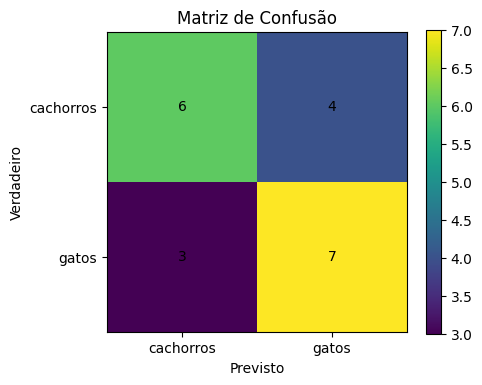

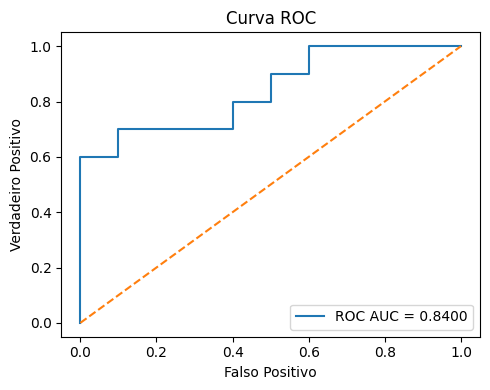

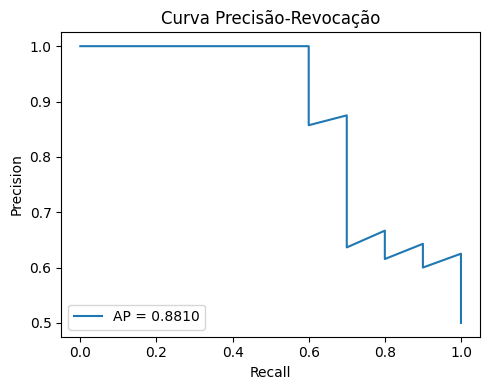

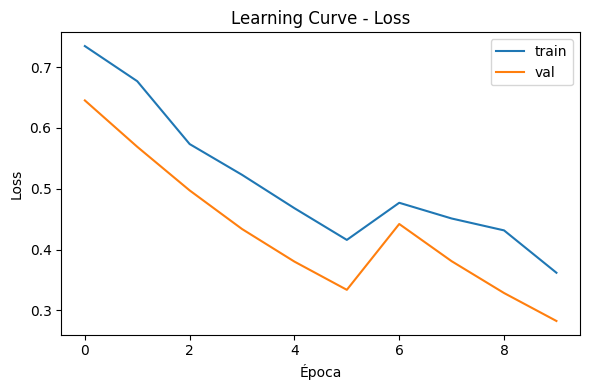

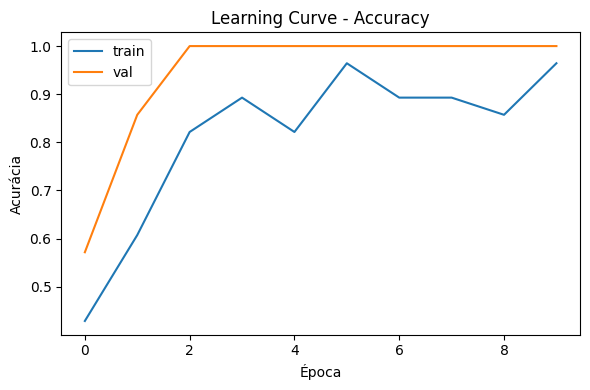

In [ ]:
# y_true / y_scores / y_pred
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, average_precision_score, precision_recall_curve

y_true   = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_scores = model.predict(test_ds, verbose=0).ravel()
y_pred   = (y_scores >= 0.5).astype(int)

# Confusion matrix + report
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
print("Matriz de confusão:\n", cm)
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=CLASSES, digits=4))

fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(cm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=[0,1], yticks=[0,1], xticklabels=CLASSES, yticklabels=CLASSES,
       xlabel='Previsto', ylabel='Verdadeiro', title='Matriz de Confusão')
for i in range(2):
    for j in range(2):
        ax.text(j, i, int(cm[i,j]), ha='center', va='center')
plt.tight_layout(); plt.show()

# ROC
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.4f}')
plt.plot([0,1],[0,1],'--')
plt.xlabel('Falso Positivo'); plt.ylabel('Verdadeiro Positivo'); plt.title('Curva ROC')
plt.legend(loc='lower right'); plt.tight_layout(); plt.show()

# PR
prec, rec, _ = precision_recall_curve(y_true, y_scores)
ap = average_precision_score(y_true, y_scores)
plt.figure(figsize=(5,4))
plt.plot(rec, prec, label=f'AP = {ap:.4f}')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Curva Precisão-Revocação')
plt.legend(loc='lower left'); plt.tight_layout(); plt.show()

# Learning curves (junta history1+history2)
def merge_hist(h1, h2):
    out={}
    for k in set(list(h1.history.keys())+list(h2.history.keys())):
        out[k] = h1.history.get(k,[])+h2.history.get(k,[])
    return out

hist = merge_hist(history1, history2)
plt.figure(figsize=(6,4))
plt.plot(hist['loss'], label='train'); plt.plot(hist['val_loss'], label='val')
plt.xlabel('Época'); plt.ylabel('Loss'); plt.title('Learning Curve - Loss'); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(hist['accuracy'], label='train'); plt.plot(hist['val_accuracy'], label='val')
plt.xlabel('Época'); plt.ylabel('Acurácia'); plt.title('Learning Curve - Accuracy'); plt.legend(); plt.tight_layout(); plt.show()
